# Generate processed data
Here we will combine the subset of reviews with their labels and associated property description to create a processed dataset.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# Which GEO to process?
GEO = "texas"

In [69]:
# load all the relevant data
DATA_FP = "../../data"
LABELS = pd.read_csv(DATA_FP + f"/labels/{GEO}_reviews_labels.csv")
SUBSET = pd.read_csv(DATA_FP + f"/filtered/{GEO}_reviews_filtered.csv")
LISTINGS = pd.read_csv(DATA_FP + f"/raw/{GEO}_listings.csv", encoding="unicode_escape", low_memory=False)

For now, we are dropping labels of "maybe". These are reviews we weren't sure about the label of. If we need more training data, we can revisit these reviews for labeling.

In [70]:
maybes = LABELS[LABELS.label == "maybe"]
print(f"Number of maybe reviews: {len(maybes)}/{len(LABELS)}")

LABELS = LABELS[LABELS.label != "maybe"]

Number of maybe reviews: 11/633


Join datasets together.

In [71]:
# join with labels
subset_with_labels = pd.merge(LABELS, SUBSET, on="id", suffixes=("_labels", "_subset"))

# join with listings
subset_labels_and_listing = pd.merge(subset_with_labels, LISTINGS, left_on="listing_id", right_on="id", suffixes=("","_listings"))

Keep only the columns we need for the processed dataset. Also, rename the columns to be more descriptive, and clean the amentities column.

In [72]:
cols_to_keep =[
    "id",
    "listing_id",
    "description",
    "comments",
    "sentiment",
    "label",
    "name",
    "amenities"
]

subset_labels_and_listing = subset_labels_and_listing[cols_to_keep]

# rename id to review_id, for clarity
subset_labels_and_listing = subset_labels_and_listing.rename(columns={"id": "review_id"})

def parse_amenities(amenities):
  amenities = amenities.replace("{", "").replace("]", "").replace('"', "")
  return amenities.split(",")

subset_labels_and_listing.amenities = subset_labels_and_listing.amenities.apply(parse_amenities)

subset_labels_and_listing.sample(n=5)

,review_id,listing_id,description,comments,sentiment,label,name,amenities
99,146634599,76911,Straddling the uneven line between AustinÛªs ...,We really enjoyed staying at Peter's place for...,4.5,no,EastSideLavishness- A Stay of comfort and Joy,"[TV, Internet, Wifi, Air conditioning, Kitchen..."
573,18588354,751847,"Gorgeous 1 story, 4 bedroom, 2 bath home - com...",Overall the house was fine. Neighborhood is o...,4.0,bad,Newly Remodeled 4 Bedroom Home,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
70,1523026,69810,Curl up with a book on the comfy window seat o...,"Well, the reviews don't lie! The Cozy Casita i...",4.5,no,"Live Beneath Live Oaks in a Bright, Intimate H...","[TV, Internet, Wifi, Air conditioning, Kitchen..."
574,55833301,751847,"Gorgeous 1 story, 4 bedroom, 2 bath home - com...",The space was perfect for our group of 8 adult...,4.0,no,Newly Remodeled 4 Bedroom Home,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
321,21751769,347736,*Please note: I can only accommodate two-night...,The apartment was clean and in a very handy lo...,4.0,no,Modern downtown loft on 6th St,"[TV, Cable TV, Wifi, Air conditioning, Kitchen..."


## Cleaning text columns

We need to clean the text columns to make them more useful for our model. We will do the following:

- Convert to lowercase
- Remove punctuation
- Remove stop words
- Lemmatize words

We will use nltk to do this.

In [73]:
# import necessary libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') # this will tokenize and remove punctuation

# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# download lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(tokens):
    processed_tokens = []
    for w in tokens:
        if w in stop_words:
            continue
        lemmatized = lemmatizer.lemmatize(w)
        processed_tokens.append(lemmatized)

    return processed_tokens

def preprocess_text(text):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return remove_stopwords_and_lemmatize(tokens)

print("Preprocessing description...")
subset_labels_and_listing.description = subset_labels_and_listing.description.apply(preprocess_text)

print("Preprocessing comments...")
subset_labels_and_listing.comments = subset_labels_and_listing.comments.apply(preprocess_text)

print("Preprocessing name...")
subset_labels_and_listing.name = subset_labels_and_listing.name.apply(preprocess_text)

subset_labels_and_listing.sample(n=5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing description...
Preprocessing comments...
Preprocessing name...


,review_id,listing_id,description,comments,sentiment,label,name,amenities
590,39789787,776713,"[amazing, sunlight, filled, house, south, aust...","[charlie, recommendation, charlie, home, warm,...",4.000000,no,"[amazing, sunlight, filled, house]","[TV, Internet, Wifi, Air conditioning, Kitchen..."
360,8712775,362662,"[downtown, central, austin, best, location, hu...","[robert, house, awesome, plenty, room, large, ...",4.500000,no,"[downtown, central, austin, huge, house]","[TV, Cable TV, Internet, Wifi, Air conditionin..."
74,12327468,72706,"[located, heart, one, austin, hottest, neighbo...","[yes, walkable, charming, central, clean, host...",3.500000,no,"[july, price, drop, great, central, soco, cott...","[TV, Internet, Wifi, Air conditioning, Kitchen..."
121,3522461,78974,"[quiet, neighborhood, minute, dt, austin, soco...","[great, stay, backyard, private, serene, refug...",4.000000,no,"[78704, detached, garden, cottage]","[TV, Cable TV, Internet, Wifi, Air conditionin..."
165,112592749,166561,"[cute, well, appointed, rental, incredible, ar...","[exactly, looking, long, story, short, flew, w...",4.666667,no,"[soco, itz, bitz, bungalow]","[TV, Cable TV, Internet, Wifi, Air conditionin..."


## Quick EDA on the processed dataset

First, let's look at the distribution of labels in the processed dataset.

% of data with label 'yes': 12.0


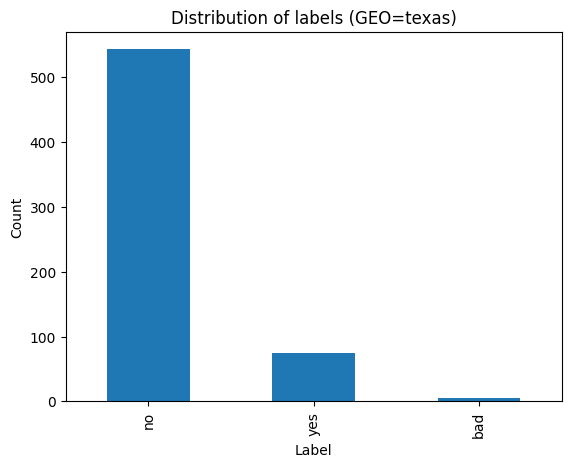

In [74]:
print(
    "% of data with label 'yes':", 
    round(len(subset_labels_and_listing[subset_labels_and_listing.label == "yes"])/len(subset_labels_and_listing), 2) * 100
)

fig = subset_labels_and_listing.label.value_counts().plot(kind="bar")
fig.set_title(f"Distribution of labels (GEO={GEO})")
fig.set_xlabel("Label")
fig.set_ylabel("Count")
plt.show()

Now let's look at a word cloud of the most common words (or groups of words for more context) in misleading reviews.

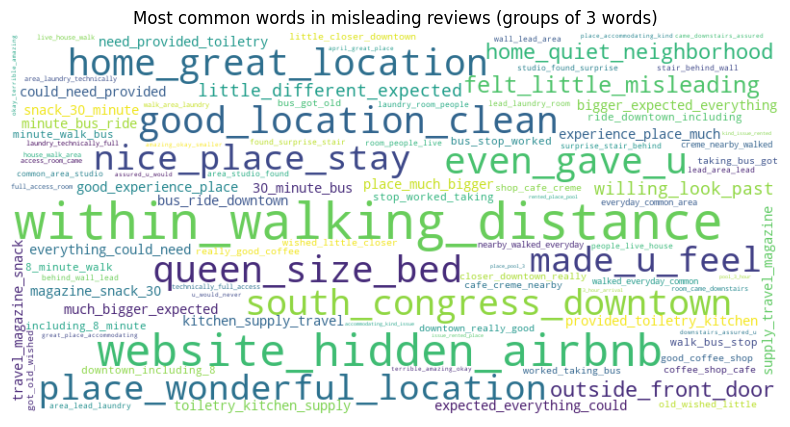

In [104]:
from wordcloud import WordCloud

# generate wordcloud for misleading reviews
misleading_reviews = subset_labels_and_listing[subset_labels_and_listing.label == "yes"]

# get groups of N consecutive words
N = 3
words = misleading_reviews.comments.apply(lambda x: [" ".join(x[i:i+N]) for i in range(len(x)-N-1)])

# combine all lists of words into one list
all_words = words.explode().apply(lambda x: "_".join(x.split(" "))).tolist()
all_words_as_string = " ".join(all_words)

wc = WordCloud(background_color="white", max_words=100, width=800, height=400).generate(all_words_as_string)

# show wordcloud using matplotlib
plt.figure(figsize=(10,5))
plt.title(f"Most common words in misleading reviews (groups of {N} words)")
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [102]:
# save it
subset_labels_and_listing.to_csv(DATA_FP + f"/processed/{GEO}_processed.csv", index=False)